## Imports

In [13]:
#import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from IPython.display import display, clear_output 
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPRegressor
import time
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

## Import and Format Data

In [2]:
## load the data
train = pd.read_csv("../p_final/training.csv")
test = pd.read_csv("../p_final/test.csv")
sample = pd.read_csv("../p_final/SampleSubmission.csv")
ID = pd.read_csv("../p_final/IdLookupTable.csv")

In [3]:
## some labels are missing, so we will drop na values from the training set
train = train.dropna()

In [4]:
## This is mostly Harry Xu's code :) #

def create_training(train_csv):
    num_samples = len(train_csv)
    n_train = int(0.8*num_samples)
    n_dev = num_samples - n_train
    
    label_names = train_csv.columns.tolist()[:-1]
    labels = train_csv.loc[:, train_csv.columns != 'Image'].values

    data = train_csv['Image'].str.split()
    data = np.vstack(data.apply(lambda row: np.asarray([int(n) for n in row])).values)
    data = data/255.0 # Rescale grayscale values to [0,1].
    
    # Shuffle the data
    shuffle = np.random.permutation(np.arange(data.shape[0]))
    data, labels = data[shuffle], labels[shuffle]
    
    # Splitting into dev and training
    dev_data, dev_labels = data[:n_dev], labels[:n_dev]
    train_data, train_labels = data[n_dev:], labels[n_dev:]
    
    return dev_data, dev_labels, train_data, train_labels, label_names

In [5]:
dev_data, dev_labels, train_data, train_labels, label_names = create_training(train)

## SKLearn - MLPRegressor

http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor

Scikit Learn's multi-layer Perceptron Regressor provides a more familiar version of a Neural Network model. We start using the default options. This is really convenient because we have a total of 30 labels for our data output, which has proven to be difficult with initial attempts using other modeling options (such as TensorFlow).

Defaults for MLPRegressor:

 * 1 hidden layer with 100 neurons
 * Activation function: relu’, the rectified linear unit function, returns f(x) = max(0, x)
 * Optimizer: adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
 * many other parameters to look at

In [6]:
sk_nn = MLPRegressor()
sk_nn.fit(train_data, train_labels)
sk_nn.score(dev_data, dev_labels)

-6.7247033030656089

In [7]:
preds = sk_nn.predict(dev_data)

In [24]:
y1_hat = np.vstack(preds[0])
y1 = np.vstack(dev_labels[0])
print(np.sum((y1 - y1_hat)**2))
print(np.sum((y1 - y1_hat)**2) / len(y1_hat))
print(np.sqrt(np.sum((y1 - y1_hat)**2) / len(y1_hat)))

977.014508049
32.5671502683
5.70676355462


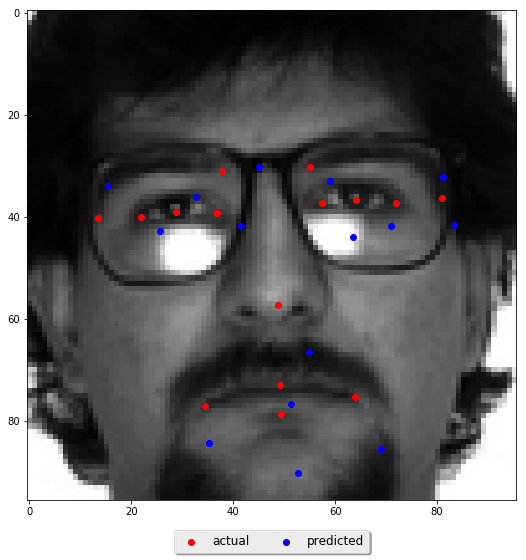

In [17]:
plt.imshow(dev_data[0].reshape(96,96), cmap='gray')
plt.scatter(dev_labels[0,0], dev_labels[0,1], color='red', label='actual')
plt.scatter(preds[0,0], preds[0,1], color='blue', label='predicted')
i = 2
while i < 29:
    plt.scatter(dev_labels[0,i], dev_labels[0,i+1], color='red')
    plt.scatter(preds[0,i], preds[0,i+1], color='blue')
    i += 2
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True,      shadow=True, ncol=2, fontsize=12)

In [27]:
def evaluate(preds, labels):
    preds, labels = np.vstack(preds), np.vstack(labels)
    return np.sqrt(np.sum((labels - preds)**2) / (30*len(preds)))

Using the default MLPRegressor() we get a result better than our baseline, but there is a lot of room for improvement:

In [28]:
print(evaluate(preds, dev_labels))

8.7228980756


#### MLP Regressor - Take 2 ####

For the next MLPRegressor() model, we are making two significant changes to the model:

 * two hidden layers of size 400 & 200
 * using the logistic activation function

In [29]:
sk_nn_1 = MLPRegressor(hidden_layer_sizes=(400,200), activation= 'logistic')
sk_nn_1.fit(train_data, train_labels)
sk_nn_1.score(dev_data, dev_labels)
preds_1 = sk_nn_1.predict(dev_data)

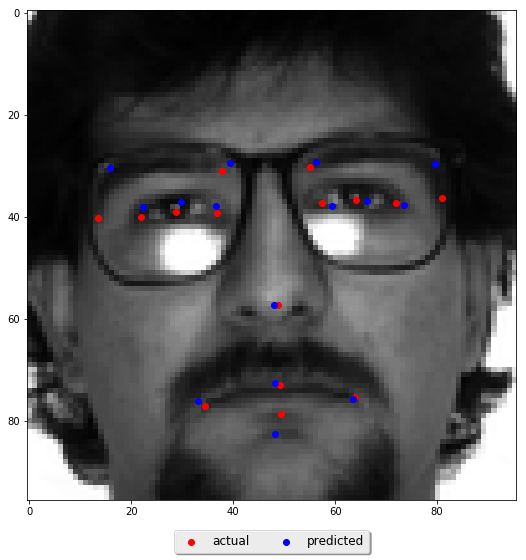

In [30]:
plt.imshow(dev_data[0].reshape(96,96), cmap='gray')
plt.scatter(dev_labels[0,0], dev_labels[0,1], color='red', label='actual')
plt.scatter(preds_1[0,0], preds_1[0,1], color='blue', label='predicted')
i = 2
while i < 29:
    plt.scatter(dev_labels[0,i], dev_labels[0,i+1], color='red')
    plt.scatter(preds_1[0,i], preds_1[0,i+1], color='blue')
    i += 2
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True,      shadow=True, ncol=2, fontsize=12)

In [31]:
print(evaluate(preds_1, dev_labels))

3.14140460135


## Running Predictions and Generating Submission File##

With the model adjustments we've significantly improved the performance on our dev set. At this point, we can put together a submission file to make sure we have our best model performance on record.

First we will need to run the model on the test data labels. Then we'll create a function that will take the predicted outputted from our model and generate a csv that matches the Kaggle comp format.

In [33]:
print(test.head())
print(len(test))

   ImageId                                              Image
0        1  182 183 182 182 180 180 176 169 156 137 124 10...
1        2  76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2        3  177 176 174 170 169 169 168 166 166 166 161 14...
3        4  176 174 174 175 174 174 176 176 175 171 165 15...
4        5  50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...
1783


In [36]:
test_data = test['Image'].str.split()
test_data = np.vstack(test_data.apply(lambda row: np.asarray([int(n) for n in row])).values)
test_data = test_data/255.0
test_preds = sk_nn_1.predict(test_data)

In [61]:
def sub_gen(predictions):
    df = pd.DataFrame(predictions, columns=train.columns[:-1])
    pos = []
    for index, row in ID.iterrows():
        pos.append((
            row['RowId'],
            df.iloc[row.ImageId - 1][row.FeatureName],
        ))

    sub = pd.DataFrame(pos, columns=('RowId', 'Location'))
    sub.to_csv("./sub111817.csv", index=False)

In [62]:
sub_gen(test_preds)

In [63]:
## Checking the submission .csv
df_sub_check = pd.read_csv("./sub111817.csv")

In [65]:
print(len(df_sub_check))
print(len(ID))

27124
27124
